In [ ]:
from google.colab import drive
drive.mount('/content/drive')
noReg='/content/drive/MyDrive/myProject/Online adversarial attack/model.h5'
reg2Link='/content/drive/MyDrive/myProject/Online adversarial attack/MNIST/reg2model.h5' #r2 s=1
reg1Link='/content/drive/MyDrive/myProject/Online adversarial attack/MNIST/reg1model.h5'#r1 s=1
fmnistLink='/content/drive/MyDrive/myProject/Online adversarial attack/FMNIST/fmodel.h5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import copy
import tensorflow_hub as hub
import matplotlib
from tensorflow.python.keras import regularizers
from keras.regularizers import l1
from keras.regularizers import l2
from keras.layers import InputLayer
from IPython.display import clear_output 
import os
import distutils

x_train = y_train = x_test = y_test = None
num_classes = 10
input_shape = (28, 28, 1)
batch_size = 128
epochs = 60
epsilon = 2/255
success = 0
shots = 10
alpha = np.exp(-2)
stream_length = 10000
select = []
result = None
ground_truth = None
vals = []
online = None
mother_result = None
mother_stream = None
mother_ground_truth = None
mother_flag = False
mother_initial_probability = None
mother_friendly_probability = None
mother_real_loss=None
real_loss=None
friendly_probability=None
initial_probability=None
secretary_chosen=[]
hard_chosen=[]
random_success=[]
secretary_success=[]
HLGRatio=[]
LLGRatio=[]
midsuc=0
mlg=0
fr=[]
indices=[]
model = None
indices = []
s = 0
classes=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
hard = 0
indexMap=[]
friendlyTile=2
adversarialTile=2
reg_strength=1
reg_type="l2"

if reg_type=='l2':
  link=reg2Link

elif reg_type=='l1':
  link=reg1Link

else:
  link=None


friendlyEpsilon = 0.3
reg_loss = None

def calcReg(strength,mode='l1'): #other l2
  global reg_loss,model
  reg_loss=0
  
  for layer in model.layers:
    for temp in layer.weights:
      A=np.asarray(temp.numpy())

      added=None

      if mode=='l1':
        added=np.sum(A)

      elif mode=='l2':
        A=np.power(A,2)
        added=np.sum(A)
      
      else:
        raise('error')
      
      reg_loss=reg_loss+added

    
    reg_loss=reg_loss*strength
    


class element:
    def __init__(self, i, value):
        self.index = i
        self.v = value

    def __ge__(self, other):
        return self.v > other.v

    def __lt__(self, other):
        return self.v < other.v


def testImage(clean_img, adv_image, truth, pred):
    plt.imshow(adv_image - clean_img, cmap='gray', vmin=-epsilon, vmax=1)
    plt.show()


def prepareDataset():
    global x_train, y_train, x_test, y_test

    
    if distutils.version.LooseVersion(tf.__version__) <= '2.0':
      raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

        
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # add empty color dimension
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

   
    b = np.zeros((y_train.size, y_train.max()+1))
    b[np.arange(y_train.size),y_train] = 1
    y_train=copy.deepcopy(b)

    b = np.zeros((y_test.size, y_test.max()+1))
    b[np.arange(y_test.size),y_test] = 1
    y_test=copy.deepcopy(b)

    print("x_train",x_train.shape)
    print("y_train",y_train.shape)
    print("x_test",x_test.shape)
    print("y_test",y_test.shape)


def defineModel():
    global model
    reg=None

    if reg_type=='l1':
      reg=l1(reg_strength)

    elif reg_type=='l2':
      reg=l2(reg_strength)


    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu",kernel_regularizer=reg))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu",kernel_regularizer=reg))
    model.add(layers.Conv2D(16, kernel_size=(3, 3), activation="relu",kernel_regularizer=reg))
    model.add(layers.Conv2D(8, kernel_size=(3, 3), activation="relu",kernel_regularizer=reg))


    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(128, activation="relu",kernel_regularizer=reg))
    model.add(layers.Dropout(0.55))
    model.add(layers.Dense(num_classes, activation="softmax",kernel_regularizer=reg))
    model.build()


def trainModel():
    global model

  
    saveLink='/content/drive/MyDrive/myProject/Online adversarial attack/FMNIST'
    model.load_weights(fmnistLink)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.save('/content/drive/MyDrive/myProject/Online adversarial attack/FMNIST/Fashion-MNIST.h5')
    calcReg(reg_strength,reg_type)
    print(reg_loss,'reg_loss')          
    model.summary()




def perturb_vect(mode): # other possible mode : friendly,duo. duo is used for speed up and epsilon is used as friendlyEpsilon
  global highest_perturbation,lowest_perturbation
  arr=[]
  label=[]


  for i in range(10000):
    arr.append(x_test[i])
    label.append(y_test[i])
  
  arr=np.asarray(arr)
  label=np.asarray(label)

  length=10000

  cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  perturbation=np.zeros((10000,28,28,1))


  highest_loss_found=np.zeros((10000))
  lowest_loss_found=np.ones((10000))*1000
 

  if mode=='adversarial':
    highest_perturbation=np.zeros_like(perturbation)
    num=int(28/adversarialTile)
    tile=adversarialTile
    for layer in range(1):
      for i in range(num):
        for j in range(num):
          print(mode,i,j)
          plus=copy.deepcopy(arr)
          minus=copy.deepcopy(arr)

          plus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=  plus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]+epsilon
          minus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=  minus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]-epsilon

          plus=model(plus)
          minus=model(minus)
          
    
         
          plus=cce(label,plus).numpy()
          minus=cce(label,minus).numpy()
          gt=np.squeeze(np.argwhere(plus>minus))
          lt=np.squeeze(np.argwhere(plus<=minus))

          perturbation[gt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=epsilon
          arr[gt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]+=epsilon

          perturbation[lt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=-epsilon
          arr[lt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]-=epsilon

          gt=np.squeeze(np.argwhere(plus>highest_loss_found))
          lt=np.squeeze(np.argwhere(minus>highest_loss_found))

          highest_loss_found[gt]=plus[gt]
          highest_loss_found[lt]=minus[lt]

          highest_perturbation[gt,:,:,:]=perturbation[gt,:,:,:]
          highest_perturbation[lt,:,:,:]=perturbation[lt,:,:,:]

    return highest_perturbation

  elif mode=='friendly':
    num=int(28/friendlyTile)
    lowest_perturbation=np.zeros_like(perturbation)
    tile=friendlyTile
    for layer in range(1):
      for i in range(num):
        for j in range(num):
          print(mode,i,j)
          plus=copy.deepcopy(arr)
          minus=copy.deepcopy(arr)

       
          plus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=  plus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]+friendlyEpsilon
          minus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=  minus[:,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]-friendlyEpsilon

          plus=model(plus)
          minus=model(minus)
          
    
         
          plus=cce(label,plus).numpy()
          minus=cce(label,minus).numpy()
          gt=np.squeeze(np.argwhere(plus<minus))
          lt=np.squeeze(np.argwhere(plus>=minus))

          perturbation[gt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=friendlyEpsilon
          arr[gt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]+=friendlyEpsilon

          perturbation[lt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]=-friendlyEpsilon
          arr[lt,i*tile:(i+1)*tile , j*tile:(j+1)*tile,0]-=friendlyEpsilon

          gt=np.squeeze(np.argwhere(plus<lowest_loss_found))
          lt=np.squeeze(np.argwhere(minus<lowest_loss_found))

          lowest_loss_found[gt]=plus[gt]
          lowest_loss_found[lt]=minus[lt]

          lowest_perturbation[gt,:,:,:]=perturbation[gt,:,:,:]
          lowest_perturbation[lt,:,:,:]=perturbation[lt,:,:,:]

    return lowest_perturbation

  else:
    raise('error. invalid mode')


def evalModel():
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

  # other possible mode : friendly
def perturb_one(idx,mode='adversarial'): # other possible mode : friendly,duo. duo is used for speed up and epsilon is used as friendlyEpsilon

  y=np.expand_dims(y_test[idx],axis=0)
  temp=np.squeeze(x_test[idx])
  x=copy.deepcopy(temp)
  highest_loss_found=None
  lowest_loss_found=None
  highest_perturbation=None
  lowest_perturbation=None

  

  cce = tf.keras.losses.CategoricalCrossentropy()
  perturbation=np.zeros((28,28))
  num=int(28/tile)

  if mode=='adversarial':

    for i in range(num):
      for j in range(num):
        plus=copy.deepcopy(x)
        minus=copy.deepcopy(x)

        plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=  plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]+epsilon
        minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=  minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]-epsilon


        plus=np.expand_dims(plus,axis=(0,-1))
        minus=np.expand_dims(minus,axis=(0,-1))
        plus=model(plus)
        minus=model(minus)
        plus=cce(y,plus).numpy()
        minus=cce(y,minus).numpy()
        
        if plus>minus:
          perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=epsilon
          x[i*tile:(i+1)*tile , j*tile:(j+1)*tile]+=epsilon

          if highest_loss_found==None or plus>highest_loss_found:
            highest_loss_found=plus
            highest_perturbation=copy.deepcopy(perturbation)



        else:
          perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=-epsilon
          x[i*tile:(i+1)*tile , j*tile:(j+1)*tile]-=epsilon

          if highest_loss_found==None or minus>highest_loss_found:
              highest_loss_found=minus
              highest_perturbation=copy.deepcopy(perturbation)
              

    return highest_perturbation



  elif mode=='friendly':

    for i in range(num):
      for j in range(num):
        plus=copy.deepcopy(x)
        minus=copy.deepcopy(x)

        plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=  plus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]+friendlyEpsilon
        minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=  minus[i*tile:(i+1)*tile , j*tile:(j+1)*tile]-friendlyEpsilon


        plus=np.expand_dims(plus,axis=(0,-1))
        minus=np.expand_dims(minus,axis=(0,-1))
        plus=model(plus)
        minus=model(minus)
        plus=cce(y,plus).numpy()
        minus=cce(y,minus).numpy()
        
        if plus>minus:
          perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=-friendlyEpsilon
          x[i*tile:(i+1)*tile , j*tile:(j+1)*tile]-=friendlyEpsilon

          if lowest_loss_found==None or minus<lowest_loss_found:
            lowest_loss_found=minus
            lowest_perturbation=copy.deepcopy(perturbation)



        else:
          perturbation[i*tile:(i+1)*tile , j*tile:(j+1)*tile]=friendlyEpsilon
          x[i*tile:(i+1)*tile , j*tile:(j+1)*tile]+=friendlyEpsilon

          if lowest_loss_found==None or plus<lowest_loss_found:
              lowest_loss_found=plus
              lowest_perturbation=copy.deepcopy(perturbation)

    return lowest_perturbation


  else:
      raise Exception("invalid mode")
      

def assess(index, metric="Loss"):
    global success
    x = np.expand_dims(x_test[index], axis=0)
    y_expanded = np.expand_dims(y_test[index], axis=0)

    cce = tf.keras.losses.CategoricalCrossentropy()
    y=model(x)
    initLoss= cce(y_expanded, y)


    perturbation = perturb(index,'adversarial')
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp = x + perturbation
    perturbation = perturb(index,'friendly')
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xf = x + perturbation
    yf = model(xf)
    y = model(xp)
    pr = np.argmax(y)
    successed = True


    if pr == np.argmax(y_test[index]):
        successed = False
    loss = cce(y_expanded, y)
    friendlyLoss=cce(y_expanded, yf)
    return (loss+reg_loss, successed, initLoss+reg_loss,friendlyLoss+reg_loss,loss)#friendlyLoss+reg_loss


def generate_stream_data(load):
    global result, ground_truth, mother_result,mistake, mother_stream, mother_ground_truth, mother_flag, mother_initial_probability, mother_friendly_probability,friendly_probability,initial_probability
    global mother_real_loss,real_loss,defsuc,deffail,midsuc,mlg,stream_length,lowest_perturbation,highest_perturbation,indexMap,arr

    lower = 0.6931471824645996
    upper = 2.3025851249694824

    defsuc = 0
    midsuc=0
    deffail = 0

    if mother_flag == False:

      mother_flag = True
      arr=[]
      label=[]
 
      if load==False:


        highest_perturbation=perturb_vect('adversarial')

        sl='/content/drive/MyDrive/myProject/Online adversarial attack/FMNIST/highest_pert_'+str(adversarialTile)+'_'+str(epsilon)
        np.save(sl,highest_perturbation) 

        lowLink='/content/drive/MyDrive/myProject/Online adversarial attack/FMNIST/lowest_pert_'+str(friendlyTile)+'_'+str(friendlyEpsilon)+'.npy'
        lowest_perturbation=np.load(lowLink)

      

         
      elif load==True:
        lowLink='/content/drive/MyDrive/myProject/Online adversarial attack/FMNIST/lowest_pert_'+str(friendlyTile)+'_'+str(friendlyEpsilon)+'.npy'
        highLink='/content/drive/MyDrive/myProject/Online adversarial attack/FMNIST/highest_pert_'+str(adversarialTile)+'_'+str(epsilon)+'.npy'

        lowest_perturbation=np.load(lowLink)
        highest_perturbation=np.load(highLink)


       
       

        lowest_perturbation=np.expand_dims(lowest_perturbation,axis=(-1))
        highest_perturbation=np.expand_dims(highest_perturbation,axis=(-1))

      
      for i in range(10000):
        arr.append(x_test[i])
        label.append(y_test[i])
        indexMap.append(i)
      

      indexMap=np.asarray(indexMap)
      arr=np.asarray(arr)
      label=np.asarray(label)
    
      init=model(arr)
      mistake=np.not_equal(np.argmax(label,axis=(1)), np.argmax(init,axis=(1)))
      mistake=np.where(mistake)
   

      cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
     


      arr=np.delete(arr,mistake,axis=(0))
      label=np.delete(label,mistake,axis=(0))
      
      indexMap=np.delete(indexMap,mistake,axis=(0))

      mother_initial_probability=(cce(label,model(arr))+reg_loss).numpy()
      lowest_perturbation=np.delete(lowest_perturbation,mistake,axis=(0))
      highest_perturbation=np.delete(highest_perturbation,mistake,axis=(0))


      lowest_perturbation=np.squeeze(lowest_perturbation)
      lowest_perturbation=np.expand_dims(lowest_perturbation,axis=(-1))

      highest_perturbation=np.squeeze(highest_perturbation)
      highest_perturbation=np.expand_dims(highest_perturbation,axis=(-1))


      lowest_perturbation=arr+lowest_perturbation
      highest_perturbation=arr+highest_perturbation

     

      predict=model(highest_perturbation)

      mother_ground_truth=(cce(label,model(highest_perturbation))+reg_loss).numpy()
      mother_result=np.not_equal(np.argmax(label,axis=(1)), np.argmax(predict,axis=(1)))
      mother_friendly_probability=(cce(label,model(lowest_perturbation))+reg_loss).numpy()
      mother_real_loss= (mother_ground_truth-reg_loss)

      # print(highest_perturbation.shape)
      # print(mother_ground_truth.sahpe)
      # print(mother_result.shape)
      # print(mother_friendly_probability.shape)
      # print(mother_real_loss.shape)



      lower=0.6931471824645996
      upper=2.3025851249694824

      for i in range(mother_real_loss.shape[0]):
        if mother_real_loss[i]>upper:
          defsuc+=1
        
        if mother_real_loss[i] <lower:
          deffail+=1

        
        if mother_real_loss[i]>=lower and mother_real_loss[i]<=upper:
          mlg+=1

          if mother_result[i]:
            midsuc+=1
      
      print("defsuc: ",defsuc)
      print("deffail: ",deffail)
      print("mlg: ",mlg)
      print("midsuc: ",midsuc)

      if not (load==True or load==False):
        raise('invalid generation mode')
    
    idx = np.random.permutation(np.arange(mother_ground_truth.shape[0]))

    result = mother_result[idx]
    ground_truth = mother_ground_truth[idx]
    friendly_probability=mother_friendly_probability[idx]
    initial_probability=mother_initial_probability[idx]
    real_loss=mother_real_loss[idx]


def onlineAttack(verbose=False):
  global ground_truth,vals,s,indices,hard,initial_probability,friendly_probability,stream_length
  t=int(alpha*stream_length)
  R=[]
  choosen_sum=0
  indices=[]
  vals=[]
  hard=0

  lower=0.6931471824645996
  upper=2.3025851249694824
  remainedShots=shots
  best_estimated_regularization=1000000
  stream_length=mother_ground_truth.shape[0]


  for i in range(stream_length):
      best_estimated_regularization=min(friendly_probability[i],initial_probability[i],best_estimated_regularization)  
      ground_truth[i]=ground_truth[i]-best_estimated_regularization

    

      if verbose:
        print("best estimation : ",best_estimated_regularization," current friendly loss : ",friendly_probability[i]," current ce loss : ",ground_truth[i]," init probability : ",initial_probability[i],"real loss : ",real_loss[i])
  

  for i in range (t):
    if len(indices)>=shots:
      break
    if ground_truth[i]<lower:

      continue
    if ground_truth[i]>upper:
      hard+=1
      remainedShots-=1
      indices.append(i)

      while len(R)>remainedShots:
        R.pop(0)
        
        

      continue

    if len(R)<remainedShots:
      R.append(ground_truth[i])

    elif len(R)==remainedShots:
      R.sort()

    else:
      if ground_truth[i]>R[0]:
        R[0]=ground_truth[i]
        R.sort()
  

  for i in range(t,stream_length):
    if len(indices)>=shots:
      break

    if ground_truth[i]<lower:
      continue

    if ground_truth[i]>upper: 
      indices.append(i)
      remainedShots-=1
      hard+=1
      while len(R)>remainedShots and len(R)>0:
        R.pop(0)
        ("pre len(R)=",len(R),"len(indices):",len(indices))
      continue

   
    if len(R)>0 and ground_truth[i]>R[0]:
      indices.append(i)

      if len(R)==remainedShots:
        R[0]=copy.deepcopy(ground_truth[i])

      else:
        R.append(copy.deepcopy(ground_truth[i]))
        
      choosen_sum+=R[0]
      vals.append(copy.deepcopy(R[0]))
      R.sort()
      continue

    if len(R)==0:
      indices.append(i)
      R.append(copy.deepcopy(ground_truth[i]))
      choosen_sum+=R[0]
      vals.append(copy.deepcopy(R[0]))


    
    if stream_length-i == shots - len(indices):
      for j in range (i,stream_length):
        if ground_truth[j]<lower:
          continue
        indices.append(j)
        vals.append(copy.deepcopy(ground_truth[j]))
        choosen_sum+=ground_truth[j]
      break

  s=0

  for i in indices:
    if result[i]:
      s+=1
  

  hard_chosen.append(hard)
  secretary_chosen.append(len(indices)-hard)
  
  fr.append(s/shots)


fool_rate=[]
success_avg=[]
success_std=[]
fail_avg=[]
fail_std=[]
total_avg=[]
total_std=[] 



def plot(show=False):
  global result,ground_truth,vals,hard,indices,hard_chosen,secretary_chosen,secretary_success,fr,real_loss,HLGRatio,MLGRatio
  lower=0.6931471824645996
  upper=2.3025851249694824
  mlg_success=0

  for i in indices:
   
  
    if ground_truth[i]<= upper and ground_truth[i]>=lower and result[i] :
      mlg_success+=1

  if secretary_chosen[-1]>0:
    secretary_success.append(mlg_success/secretary_chosen[-1])

  mysuc=0
  myfail=0

  for i in range(stream_length):
    if ground_truth[i]>=upper:
      mysuc+=1
    
    if ground_truth[i]<=lower:
      myfail+=1

  HLGRatio.append(mysuc)
  LLGRatio.append(myfail)
      


def randomSelectionInMLG():
  mlg=0
  success=0
  lower=0.6931471824645996
  upper=2.3025851249694824

  for i in range(stream_length):
     if ground_truth[i]-reg_loss<= upper and ground_truth[i]>=lower:
       mlg+=1

       if result[i]:
         success+=1
  
  return success/mlg


def randomSelectionNotKnowingM():
  total=0
  success=0
  lower=0.6931471824645996
  upper=2.3025851249694824

  for i in range(stream_length):
     if ground_truth[i]>=lower:
       total+=1
       
       if result[i]:
         success+=1


  return success/total


#########################################################################################################################
pepareDataset()
defineModel()
trainModel()
evalModel()
generate_stream_data(True)
onlineAttack()

x_train (60000, 28, 28, 1)
y_train (60000, 10)
x_test (10000, 28, 28, 1)
y_test (10000, 10)
1080.0961165730841 reg_loss
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 16)        4624      
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 8)         1160      
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dropout_4 (Dropout)         (None, 3200)              0         


In [ ]:
hard_chosen=[]
secretary_chosen=[]
secretary_success=[]
fr=[]
shots=10
iter=1000


for i in range(iter):
  if i%100==0:
    print(i)
    
  generate_stream_data(True)
  onlineAttack()
  plot()


generate_stream_data(True)
# onlineAttack(True)

fr=np.asarray(fr, dtype=np.float32)
secretary_success=np.asarray(secretary_success, dtype=np.float32)

secretary_chosen=np.asarray(secretary_chosen, dtype=np.float32)
hard_chosen=np.asarray(hard_chosen, dtype=np.float32)

print("These are general results yielded for ",iter," number of random permutations")
print("average fool rate under my assumption : ",np.mean(fr),np.std(fr))

print("average success for secretary chosen data : ",np.mean(secretary_success),np.std(secretary_success))
print("average number of data chosen by secretary : ",np.mean(secretary_chosen),np.std(secretary_chosen))
print("average number of hard chosen data : ",np.mean(hard_chosen),np.std(hard_chosen))
print("average number of selected data : ",np.mean(hard_chosen+secretary_chosen),np.std(hard_chosen+secretary_chosen))
print("random choice not knowing m success rate : ",randomSelectionNotKnowingM())
print("mean HLG grouped : ",np.mean(np.asarray(HLGRatio)))
print("mean LLG grouped : ",np.mean(np.asarray(LLGRatio)))


hard_chosen=[]
secretary_chosen=[]

secretary_success=[]
fr=[]


print(np.amax(mother_friendly_probability))
print(np.amax(mother_initial_probability))




def plotShots():
  
  for i in indices:
    x= np.expand_dims(x_test[i], axis=0)
    yc=model(x)
    perturbation=fgsm(epsilon,i)
    print("perturbation shape ",perturbation.shape)
    print("x",x.shape)
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp=np.squeeze(perturbation)+np.squeeze(x)
    xp=np.expand_dims(xp,axis=(0,-1))
  
    yp=model(xp)

    if (np.argmax(yc)!=np.argmax(yp)) and (result[i] != -1):
      testImage(np.squeeze(x),np.squeeze(xp),np.argmax(yc),np.argmax(yp))

#plotShots()



0
100
200
300
400
500
600
700
800
900
These are general results yielded for  1000  number of random permutations
average fool rate under my assumption :  1.0 0.0
average success for secretary chosen data :  nan nan
average number of data chosen by secretary :  0.0 0.0
average number of hard chosen data :  10.0 0.0
average number of selected data :  10.0 0.0
random choice not knowing m success rate :  0.15102974828375287
mean HLG grouped :  273.0
mean LLG grouped :  7693.0
1080.0984
1081.2346


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
hard_chosen=[]
secretary_chosen=[]
secretary_success=[]
fr=[]
shots=100
iter=1000


for i in range(iter):
  if i%100==0:
    print(i)
    
  generate_stream_data(True)
  onlineAttack()
  plot()


generate_stream_data(True)

fr=np.asarray(fr, dtype=np.float32)
secretary_success=np.asarray(secretary_success, dtype=np.float32)

secretary_chosen=np.asarray(secretary_chosen, dtype=np.float32)
hard_chosen=np.asarray(hard_chosen, dtype=np.float32)

print("These are general results yielded for ",iter," number of random permutations")
print("average fool rate under my assumption : ",np.mean(fr),np.std(fr))

print("average success for secretary chosen data : ",np.mean(secretary_success),np.std(secretary_success))
print("average number of data chosen by secretary : ",np.mean(secretary_chosen),np.std(secretary_chosen))
print("average number of hard chosen data : ",np.mean(hard_chosen),np.std(hard_chosen))
print("average number of selected data : ",np.mean(hard_chosen+secretary_chosen),np.std(hard_chosen+secretary_chosen))
print("random choice not knowing m success rate : ",randomSelectionNotKnowingM())
print("mean HLG grouped : ",np.mean(np.asarray(HLGRatio)))
print("mean LLG grouped : ",np.mean(np.asarray(LLGRatio)))


hard_chosen=[]
secretary_chosen=[]

secretary_success=[]
fr=[]


print(np.amax(mother_friendly_probability))
print(np.amax(mother_initial_probability))




def plotShots():
  
  for i in indices:
    x= np.expand_dims(x_test[i], axis=0)
    yc=model(x)
    perturbation=fgsm(epsilon,i)
    print("perturbation shape ",perturbation.shape)
    print("x",x.shape)
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp=np.squeeze(perturbation)+np.squeeze(x)
    xp=np.expand_dims(xp,axis=(0,-1))
  
    yp=model(xp)

    if (np.argmax(yc)!=np.argmax(yp)) and (result[i] != -1):
      testImage(np.squeeze(x),np.squeeze(xp),np.argmax(yc),np.argmax(yp))



0
100
200
300
400
500
600
700
800
900
These are general results yielded for  1000  number of random permutations
average fool rate under my assumption :  0.99651 0.006125344
average success for secretary chosen data :  0.991906 0.014211816
average number of data chosen by secretary :  41.31 5.9704185
average number of hard chosen data :  58.69 5.9704185
average number of selected data :  100.0 0.0
random choice not knowing m success rate :  0.15102974828375287
mean HLG grouped :  273.0
mean LLG grouped :  7693.0
1080.0984
1081.2346


In [ ]:
hard_chosen=[]
secretary_chosen=[]
secretary_success=[]
fr=[]
shots=1000
iter=1000


for i in range(iter):
  if i%100==0:
    print(i)
    
  generate_stream_data(True)
  onlineAttack()
  plot()


generate_stream_data(True)
# onlineAttack(True)

fr=np.asarray(fr, dtype=np.float32)
secretary_success=np.asarray(secretary_success, dtype=np.float32)

secretary_chosen=np.asarray(secretary_chosen, dtype=np.float32)
hard_chosen=np.asarray(hard_chosen, dtype=np.float32)

print("These are general results yielded for ",iter," number of random permutations")
print("average fool rate under my assumption : ",np.mean(fr),np.std(fr))

print("average success for secretary chosen data : ",np.mean(secretary_success),np.std(secretary_success))
print("average number of data chosen by secretary : ",np.mean(secretary_chosen),np.std(secretary_chosen))
print("average number of hard chosen data : ",np.mean(hard_chosen),np.std(hard_chosen))
print("average number of selected data : ",np.mean(hard_chosen+secretary_chosen),np.std(hard_chosen+secretary_chosen))
#print("random MLG success rate : ",randomSelectionInMLG())
print("random choice not knowing m success rate : ",randomSelectionNotKnowingM())
print("mean HLG grouped : ",np.mean(np.asarray(HLGRatio)))
print("mean LLG grouped : ",np.mean(np.asarray(LLGRatio)))


hard_chosen=[]
secretary_chosen=[]

secretary_success=[]
fr=[]


print(np.amax(mother_friendly_probability))
print(np.amax(mother_initial_probability))




def plotShots():
  
  for i in indices:
    x= np.expand_dims(x_test[i], axis=0)
    yc=model(x)
    perturbation=fgsm(epsilon,i)
    print("perturbation shape ",perturbation.shape)
    print("x",x.shape)
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp=np.squeeze(perturbation)+np.squeeze(x)
    xp=np.expand_dims(xp,axis=(0,-1))
  
    yp=model(xp)

    if (np.argmax(yc)!=np.argmax(yp)) and (result[i] != -1):
      testImage(np.squeeze(x),np.squeeze(xp),np.argmax(yc),np.argmax(yp))

#plotShots()



0
100
200
300
400
500
600
700
800
900
These are general results yielded for  1000  number of random permutations
average fool rate under my assumption :  0.950446 0.025186725
average success for secretary chosen data :  0.93521214 0.0064570783
average number of data chosen by secretary :  741.789 27.86802
average number of hard chosen data :  256.718 5.5550404
average number of selected data :  998.507 26.403603
random choice not knowing m success rate :  0.15102974828375287
mean HLG grouped :  273.0
mean LLG grouped :  7693.0
1080.0984
1081.2346


In [ ]:
#TESTING alpha sensitivity

alpha_array=[1/4*np.exp(-2),1/3*np.exp(-2),1/2*np.exp(-2),np.exp(-2),2*np.exp(-2),3*np.exp(-2),4*np.exp(-2)]
shots=1000
iter=1000

frs=[]
secsucs=[]
sec_chosens=[]
hard_chosens=[]

for alpha_value in alpha_array:

  alpha=alpha_value
  hard_chosen=[]
  secretary_chosen=[]
  secretary_success=[]
  fr=[]





  for i in range(iter):
    if i%100==0:
      print(i)
      
    generate_stream_data(True)
    onlineAttack()
    plot()


  generate_stream_data(True)
  # onlineAttack(True)

  fr=np.asarray(fr, dtype=np.float32)
  secretary_success=np.asarray(secretary_success, dtype=np.float32)

  secretary_chosen=np.asarray(secretary_chosen, dtype=np.float32)
  hard_chosen=np.asarray(hard_chosen, dtype=np.float32)
  
  sec_chosens.append(np.mean(secretary_chosen))
  hard_chosens.append(np.mean(hard_chosen))

  frs.append(fr)
  secsucs.append(secretary_success)


for i in range(len(alpha_array)):
  print("i=",i,"alpha=",alpha_array[i],"fool rate=",np.mean(frs[i]),"secretary success=",np.mean(secsucs[i]),"#sec_chosen=",secretary_chosen[i],"#hard_chosens=",hard_chosens[i])









def plotShots():
  
  for i in indices:
    x= np.expand_dims(x_test[i], axis=0)
    yc=model(x)
    perturbation=fgsm(epsilon,i)
    print("perturbation shape ",perturbation.shape)
    print("x",x.shape)
    perturbation=np.expand_dims(perturbation,axis=(0,-1))
    xp=np.squeeze(perturbation)+np.squeeze(x)
    xp=np.expand_dims(xp,axis=(0,-1))
  
    yp=model(xp)

    if (np.argmax(yc)!=np.argmax(yp)) and (result[i] != -1):
      testImage(np.squeeze(x),np.squeeze(xp),np.argmax(yc),np.argmax(yp))

#plotShots()



0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
i= 0 alpha= 0.033833820809153176 fool rate= 0.943795 secretary success= 0.9308649 #sec_chosen= 427.0 #hard_chosens= 196.488
i= 1 alpha= 0.045111761078870896 fool rate= 0.94270396 secretary success= 0.92869765 #sec_chosen= 448.0 #hard_chosens= 198.267
i= 2 alpha= 0.06766764161830635 fool rate= 0.94064504 secretary success= 0.9273352 #sec_chosen= 456.0 #hard_chosens= 202.643
i= 3 alpha= 0.1353352832366127 fool rate= 0.94208395 secretary success= 0.9273743 #sec_chosen= 434.0 #hard_chosens= 218.268
i= 4 alpha= 0.2706705664732254 fool rate= 0.94975704 secretary success= 0.93479514 #sec_chosen= 468.0 #hard_chosens= 256.675
i= 5 alpha= 0.4060058497098381 fool rate= 0.862441 secretary success= 0.9418781 #sec_chosen= 417.0 #hard_chos

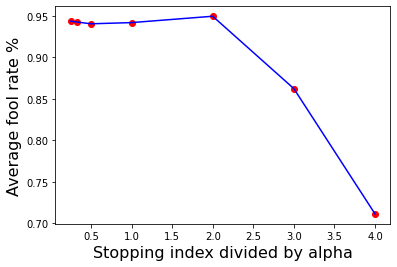

7 7


In [ ]:
a1=np.mean(np.asarray(frs),axis=1)
# b1=np.arange(len(alpha_array))
b1=np.asarray(alpha_array)/np.exp(-2)

# plt.plot(b1, a1, 'xb-')
plt.scatter(b1,a1,color='r',zorder=1)
plt.plot(b1,a1,color='b',zorder=2)

plt.xlabel('Stopping index divided by alpha',fontsize=16)
plt.ylabel('Average fool rate %',fontsize=16)

plt.show()

print(len(frs),len(alpha_array))